In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np

In [4]:
TRAIN_DATA_DIR = './cats_and_dogs_small/train'
VALIDATION_DATA_DIR = './cats_and_dogs_small/validation'
TEST_DATA_DIR = './cats_and_dogs_small/test'

TRAIN_SAMPLES = 800*2
VALIDATION_SAMPLES = 400*2 
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# We don't augment data for validation dataset!

In [6]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 1600 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [18]:
model = MobileNet()

In [19]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [5]:
model1 = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [7]:
def model_maker():
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    print(len(base_model.layers))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [8]:
model_final = model_maker()
model_final.summary()

87
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,294,594
Trainable params: 65,730
Non-trainable params: 3,228,864
___________________________________________

In [9]:

model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
    epochs=10,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE)

Epoch 1/10
25/25 [==============================] - 21s 836ms/step - loss: 0.3327 - acc: 0.8481 - val_loss: 0.0519 - val_acc: 0.9870
Epoch 2/10
25/25 [==============================] - 20s 816ms/step - loss: 0.1052 - acc: 0.9594 - val_loss: 0.0407 - val_acc: 0.9870
Epoch 3/10
25/25 [==============================] - 20s 809ms/step - loss: 0.0774 - acc: 0.9681 - val_loss: 0.0383 - val_acc: 0.9844
Epoch 4/10
25/25 [==============================] - 21s 829ms/step - loss: 0.0685 - acc: 0.9756 - val_loss: 0.0329 - val_acc: 0.9883
Epoch 5/10
25/25 [==============================] - 21s 836ms/step - loss: 0.0601 - acc: 0.9762 - val_loss: 0.0410 - val_acc: 0.9805
Epoch 6/10
25/25 [==============================] - 21s 834ms/step - loss: 0.0861 - acc: 0.9663 - val_loss: 0.0302 - val_acc: 0.9896
Epoch 7/10
25/25 [==============================] - 21s 823ms/step - loss: 0.0575 - acc: 0.9819 - val_loss: 0.0256 - val_acc: 0.9922
Epoch 8/10
25/25 [==============================] - 20s 810ms/step - 

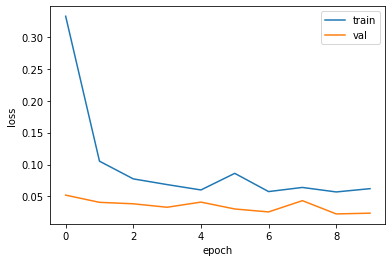

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

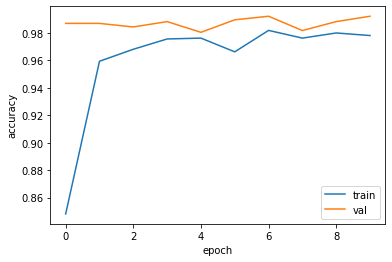

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 800 images belonging to 2 classes.


In [16]:
model_final.evaluate(test_generator, steps=800 // BATCH_SIZE,verbose=1)

12/12 [==============================] - 3s 211ms/step - loss: 0.0309 - acc: 0.9883


[0.03086053393781185, 0.98828125]

In [17]:
np.set_printoptions(suppress=True)

In [18]:
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255.  # Preprocess the image
prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))
# print(validation_generator.class_indices)

[0.99999356 0.00000646]
